<a href="https://colab.research.google.com/github/Jade-Isimbi/Prediction-Pipeline/blob/main/Database_Prediction_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymongo sqlalchemy kaggle pandas matplotlib plotly graphviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 12.3 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
from google.colab import files
import json

# Upload your kaggle.json file
print("=" * 60)
print("STEP 1: Upload your kaggle.json file")
print("=" * 60)
print("Go to: https://www.kaggle.com/settings/account")
print("Scroll down to 'API' section and click 'Create New Token'")
print("This will download kaggle.json")
print("\nNow upload it here:")

uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
print("\n" + "=" * 60)
print("STEP 2: Downloading dataset from Kaggle...")
print("=" * 60)

!kaggle datasets download -d patelris/crop-yield-prediction-dataset
!unzip -o crop-yield-prediction-dataset.zip

# Load the dataset
df = pd.read_csv('yield_df.csv')

print("\n✓ Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

STEP 1: Upload your kaggle.json file
Go to: https://www.kaggle.com/settings/account
Scroll down to 'API' section and click 'Create New Token'
This will download kaggle.json

Now upload it here:


Saving kaggle.json to kaggle.json

STEP 2: Downloading dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/patelris/crop-yield-prediction-dataset
License(s): world-bank
  0% 0.00/959k [00:00<?, ?B/s]
100% 959k/959k [00:00<00:00, 750MB/s]
Archive:  crop-yield-prediction-dataset.zip
  inflating: pesticides.csv          
  inflating: rainfall.csv            
  inflating: temp.csv                
  inflating: yield.csv               
  inflating: yield_df.csv            

✓ Dataset loaded successfully!
Dataset shape: (28242, 8)

Columns: ['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

First few rows:
   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Al

In [3]:
# ============================================================================
# PART 3: DATA PREPROCESSING AND SCHEMA DESIGN
# ============================================================================

print("\n" + "=" * 60)
print("STEP 3: Data Preprocessing")
print("=" * 60)

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Handle missing values
df = df.dropna()

# Display basic statistics
print(f"\nDataset Info:")
print(f"Total records: {len(df)}")
print(f"\nColumns and types:")
print(df.dtypes)
print(f"\nBasic statistics:")
print(df.describe())


STEP 3: Data Preprocessing

Dataset Info:
Total records: 28242

Columns and types:
unnamed:_0                         int64
area                              object
item                              object
year                               int64
hg/ha_yield                        int64
average_rain_fall_mm_per_year    float64
pesticides_tonnes                float64
avg_temp                         float64
dtype: object

Basic statistics:
         unnamed:_0          year    hg/ha_yield  \
count  28242.000000  28242.000000   28242.000000   
mean   14120.500000   2001.544296   77053.332094   
std     8152.907488      7.051905   84956.612897   
min        0.000000   1990.000000      50.000000   
25%     7060.250000   1995.000000   19919.250000   
50%    14120.500000   2001.000000   38295.000000   
75%    21180.750000   2008.000000  104676.750000   
max    28241.000000   2013.000000  501412.000000   

       average_rain_fall_mm_per_year  pesticides_tonnes      avg_temp  
count         

In [4]:
# ============================================================================
# PART 4: CREATE RELATIONAL DATABASE (SQLite)
# ============================================================================

print("\n" + "=" * 60)
print("STEP 4: Creating Relational Database (SQLite)")
print("=" * 60)

import sqlite3
from datetime import datetime

# Create connection
conn = sqlite3.connect('crop_yield.db')
cursor = conn.cursor()

# Drop existing tables if they exist
cursor.execute("DROP TABLE IF EXISTS yield_records")
cursor.execute("DROP TABLE IF EXISTS crops")
cursor.execute("DROP TABLE IF EXISTS countries")
cursor.execute("DROP TABLE IF EXISTS audit_log")

# Create Countries Table
cursor.execute("""
CREATE TABLE countries (
    country_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_name VARCHAR(100) UNIQUE NOT NULL,
    region VARCHAR(50),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
""")
# Create Crops Table
cursor.execute("""
CREATE TABLE crops (
    crop_id INTEGER PRIMARY KEY AUTOINCREMENT,
    crop_name VARCHAR(100) UNIQUE NOT NULL,
    crop_category VARCHAR(50),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
""")

# Create Yield Records Table
cursor.execute("""
CREATE TABLE yield_records (
    record_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER NOT NULL,
    crop_id INTEGER NOT NULL,
    year INTEGER NOT NULL,
    avg_temp REAL,
    avg_rainfall_mm REAL,
    pesticides_tonnes REAL,
    yield_hg_per_ha REAL,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY (country_id) REFERENCES countries(country_id),
    FOREIGN KEY (crop_id) REFERENCES crops(crop_id),
    CHECK (year >= 1900 AND year <= 2100),
    CHECK (yield_hg_per_ha >= 0)
)
""")

# Create Audit Log Table
cursor.execute("""
CREATE TABLE audit_log (
    log_id INTEGER PRIMARY KEY AUTOINCREMENT,
    table_name VARCHAR(50),
    operation VARCHAR(20),
    record_id INTEGER,
    old_value TEXT,
    new_value TEXT,
    changed_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
""")

print("✓ Tables created successfully!")


STEP 4: Creating Relational Database (SQLite)
✓ Tables created successfully!


In [5]:
# ============================================================================
# PART 5: CREATE TRIGGER
# ============================================================================

print("\n" + "=" * 60)
print("STEP 5: Creating Trigger")
print("=" * 60)

# Trigger to log updates to yield_records
cursor.execute("""
CREATE TRIGGER log_yield_updates
AFTER UPDATE ON yield_records
FOR EACH ROW
BEGIN
    INSERT INTO audit_log (table_name, operation, record_id, old_value, new_value)
    VALUES (
        'yield_records',
        'UPDATE',
        NEW.record_id,
        json_object(
            'yield', OLD.yield_hg_per_ha,
            'rainfall', OLD.avg_rainfall_mm,
            'temp', OLD.avg_temp
        ),
        json_object(
            'yield', NEW.yield_hg_per_ha,
            'rainfall', NEW.avg_rainfall_mm,
            'temp', NEW.avg_temp
        )
    );
END;
""")

# Trigger to automatically update updated_at timestamp
cursor.execute("""
CREATE TRIGGER update_timestamp
AFTER UPDATE ON yield_records
FOR EACH ROW
BEGIN
    UPDATE yield_records
    SET updated_at = CURRENT_TIMESTAMP
    WHERE record_id = NEW.record_id;
END;
""")

print("✓ Triggers created successfully!")
print("  - log_yield_updates: Logs all updates to yield_records")
print("  - update_timestamp: Auto-updates timestamp on modifications")



STEP 5: Creating Trigger
✓ Triggers created successfully!
  - log_yield_updates: Logs all updates to yield_records
  - update_timestamp: Auto-updates timestamp on modifications


In [6]:
# ============================================================================
# PART 6: CREATE STORED PROCEDURES (as Functions)
# ============================================================================

print("\n" + "=" * 60)
print("STEP 6: Creating Stored Procedures (Functions)")
print("=" * 60)

# Note: SQLite doesn't support stored procedures natively,
# so we'll create Python functions that perform the same operations

def get_crop_statistics(crop_name):
    """
    Stored Procedure: Get statistics for a specific crop
    """
    query = """
    SELECT
        c.crop_name,
        COUNT(*) as total_records,
        AVG(yr.yield_hg_per_ha) as avg_yield,
        MIN(yr.yield_hg_per_ha) as min_yield,
        MAX(yr.yield_hg_per_ha) as max_yield,
        AVG(yr.avg_temp) as avg_temperature,
        AVG(yr.avg_rainfall_mm) as avg_rainfall
    FROM yield_records yr
    JOIN crops c ON yr.crop_id = c.crop_id
    WHERE c.crop_name = ?
    GROUP BY c.crop_name
    """
    cursor.execute(query, (crop_name,))
    result = cursor.fetchone()

    if result:
        return {
            'crop_name': result[0],
            'total_records': result[1],
            'avg_yield': round(result[2], 2),
            'min_yield': round(result[3], 2),
            'max_yield': round(result[4], 2),
            'avg_temperature': round(result[5], 2),
            'avg_rainfall': round(result[6], 2)
        }
    return None

def validate_and_insert_yield_record(country_name, crop_name, year,
                                     avg_temp, avg_rainfall, pesticides, yield_val):
    """
    Stored Procedure: Validate and insert a new yield record
    """
    try:
        # Validate inputs
        if year < 1900 or year > 2100:
            return False, "Invalid year"
        if yield_val < 0:
            return False, "Yield cannot be negative"

        # Get or create country
        cursor.execute("SELECT country_id FROM countries WHERE country_name = ?", (country_name,))
        country_row = cursor.fetchone()
        if country_row:
            country_id = country_row[0]
        else:
            cursor.execute("INSERT INTO countries (country_name) VALUES (?)", (country_name,))
            country_id = cursor.lastrowid

        # Get or create crop
        cursor.execute("SELECT crop_id FROM crops WHERE crop_name = ?", (crop_name,))
        crop_row = cursor.fetchone()
        if crop_row:
            crop_id = crop_row[0]
        else:
            cursor.execute("INSERT INTO crops (crop_name) VALUES (?)", (crop_name,))
            crop_id = cursor.lastrowid

        # Insert yield record
        cursor.execute("""
            INSERT INTO yield_records
            (country_id, crop_id, year, avg_temp, avg_rainfall_mm, pesticides_tonnes, yield_hg_per_ha)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (country_id, crop_id, year, avg_temp, avg_rainfall, pesticides, yield_val))

        conn.commit()
        return True, "Record inserted successfully"

    except Exception as e:
        return False, str(e)

print("✓ Stored Procedures (Functions) created successfully!")
print("  - get_crop_statistics(crop_name)")
print("  - validate_and_insert_yield_record(...)")


STEP 6: Creating Stored Procedures (Functions)
✓ Stored Procedures (Functions) created successfully!
  - get_crop_statistics(crop_name)
  - validate_and_insert_yield_record(...)


In [7]:
# ============================================================================
# PART 7: POPULATE DATABASE (FINAL CORRECTED VERSION)
# ============================================================================

print("\n" + "=" * 60)
print("STEP 7: Populating Database (Final Corrected Version)")
print("=" * 60)

# Let's use the actual column names from the DataFrame
df_working = df.copy()

print("Actual columns in DataFrame:")
for i, col in enumerate(df_working.columns, 1):
    print(f"  {i}. '{col}'")

# Create a flexible column mapping based on actual column names
column_mapping = {
    'country_name': 'country_name',
    'crop_name': 'crop_name',
    'year': 'year',
    'yield_hg_per_ha': 'yield_hg_per_ha',
    'rainfall_mm': 'avg_rainfall_mm',  # This is the actual column name
    'pesticides_tonnes': 'pesticides_tonnes',
    'avg_temp': 'avg_temp'
}

# Verify all required columns exist
required_columns = ['country_name', 'crop_name', 'year', 'yield_hg_per_ha', 'avg_rainfall_mm', 'pesticides_tonnes', 'avg_temp']
missing_columns = [col for col in required_columns if col not in df_working.columns]

if missing_columns:
    print(f"\n⚠ Missing columns: {missing_columns}")
    print("Available columns:")
    for col in df_working.columns:
        print(f"  - '{col}'")
else:
    print(f"\n✓ All required columns found!")

# Clear existing data to start fresh
print("\nClearing existing data...")
cursor.execute("DELETE FROM yield_records")
cursor.execute("DELETE FROM countries")
cursor.execute("DELETE FROM crops")
cursor.execute("DELETE FROM audit_log")
conn.commit()
print("✓ Cleared existing data")

# Insert unique countries
print("\n1. Inserting countries...")
unique_countries = df_working['area'].unique() # Changed from country_name to area
print(f"Found {len(unique_countries)} unique countries")

countries_inserted = 0
for country in unique_countries:
    try:
        cursor.execute("INSERT INTO countries (country_name) VALUES (?)", (country,))
        countries_inserted += 1
    except Exception as e:
        # Ignore duplicate errors due to UNIQUE constraint
        if "UNIQUE constraint" not in str(e):
            print(f"Error inserting country '{country}': {e}")

conn.commit()
print(f"✓ Inserted {countries_inserted} countries")

# Insert unique crops
print("\n2. Inserting crops...")
unique_crops = df_working['item'].unique() # Changed from crop_name to item
print(f"Found {len(unique_crops)} unique crops")

crops_inserted = 0
for crop in unique_crops:
    try:
        cursor.execute("INSERT INTO crops (crop_name) VALUES (?)", (crop,))
        crops_inserted += 1
    except Exception as e:
        # Ignore duplicate errors due to UNIQUE constraint
        if "UNIQUE constraint" not in str(e):
            print(f"Error inserting crop '{crop}': {e}")

conn.commit()
print(f"✓ Inserted {crops_inserted} crops")

# Verify country and crop IDs were created
cursor.execute("SELECT COUNT(*) FROM countries")
country_count = cursor.fetchone()[0]
cursor.execute("SELECT COUNT(*) FROM crops")
crop_count = cursor.fetchone()[0]
print(f"\nDatabase now has {country_count} countries and {crop_count} crops")

# Insert yield records - USING ACTUAL COLUMN NAMES
print("\n3. Inserting yield records...")
records_inserted = 0
errors = 0

# Create a mapping dictionary for country and crop names to IDs
cursor.execute("SELECT country_id, country_name FROM countries")
country_map = {name: cid for cid, name in cursor.fetchall()}

cursor.execute("SELECT crop_id, crop_name FROM crops")
crop_map = {name: cid for cid, name in cursor.fetchall()}

# Insert records in batches for better performance
batch_size = 1000
batch_records = []

for idx, row in df_working.iterrows():
    try:
        # Use ACTUAL column names from the DataFrame
        country_name = row['area'] # Changed from country_name to area
        crop_name = row['item'] # Changed from crop_name to item
        year = int(row['year'])
        yield_value = float(row['hg/ha_yield'])
        rainfall_mm = float(row['average_rain_fall_mm_per_year'])  # This is the correct column name
        pesticides_tonnes = float(row['pesticides_tonnes'])
        avg_temp = float(row['avg_temp'])

        # Get IDs from our mapping
        country_id = country_map.get(country_name)
        crop_id = crop_map.get(crop_name)

        if not country_id:
            print(f"Warning: Country '{country_name}' not found in mapping")
            errors += 1
            continue

        if not crop_id:
            print(f"Warning: Crop '{crop_name}' not found in mapping")
            errors += 1
            continue

        # Add to batch
        batch_records.append((
            country_id, crop_id, year, avg_temp, rainfall_mm,
            pesticides_tonnes, yield_value
        ))

        # Insert batch when it reaches batch_size
        if len(batch_records) >= batch_size:
            cursor.executemany("""
                INSERT INTO yield_records
                (country_id, crop_id, year, avg_temp, avg_rainfall_mm, pesticides_tonnes, yield_hg_per_ha)
                VALUES (?, ?, ?, ?, ?, ?, ?)
            """, batch_records)
            records_inserted += len(batch_records)
            batch_records = []
            print(f"  Inserted {records_inserted} records...")

    except Exception as e:
        errors += 1
        if errors <= 3:  # Only show first few errors
            print(f"Error at row {idx}: {e}")
            print(f"  Row data: {dict(row)}")
        continue

# Insert any remaining records in the final batch
if batch_records:
    cursor.executemany("""
        INSERT INTO yield_records
        (country_id, crop_id, year, avg_temp, avg_rainfall_mm, pesticides_tonnes, yield_hg_per_ha)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, batch_records)
    records_inserted += len(batch_records)

conn.commit()

print(f"\n✓ Insertion completed!")
print(f"  Successfully inserted: {records_inserted} records")
print(f"  Errors encountered: {errors} records")
print(f"  Total processed: {records_inserted + errors} records")

# Verify the insertion
cursor.execute("SELECT COUNT(*) FROM yield_records")
final_count = cursor.fetchone()[0]
print(f"✓ Database now contains {final_count} yield records")

# Show sample of inserted data
if final_count > 0:
    print("\nSample of inserted data:")
    cursor.execute("""
        SELECT c.country_name, cr.crop_name, yr.year, yr.yield_hg_per_ha
        FROM yield_records yr
        JOIN countries c ON yr.country_id = c.country_id
        JOIN crops cr ON yr.crop_id = cr.crop_id
        LIMIT 5
    """)
    sample_data = cursor.fetchall()
    for row in sample_data:
        print(f"  {row[0]} - {row[1]} ({row[2]}): {row[3]:,.0f} hg/ha")

    # Show some statistics
    print(f"\nDatabase Statistics:")
    cursor.execute("SELECT MIN(year), MAX(year) FROM yield_records")
    min_year, max_year = cursor.fetchone()
    print(f"  Year range: {min_year} - {max_year}")

    cursor.execute("SELECT COUNT(DISTINCT country_id) FROM yield_records")
    unique_countries = cursor.fetchone()[0]
    print(f"  Countries with data: {unique_countries}")

    cursor.execute("SELECT COUNT(DISTINCT crop_id) FROM yield_records")
    unique_crops = cursor.fetchone()[0]
    print(f"  Crops with data: {unique_crops}")
else:
    print("\n⚠ No records were inserted. Debugging info:")
    print(f"  Total rows in DataFrame: {len(df_working)}")
    print(f"  First row sample: {dict(df_working.iloc[0])}")


STEP 7: Populating Database (Final Corrected Version)
Actual columns in DataFrame:
  1. 'unnamed:_0'
  2. 'area'
  3. 'item'
  4. 'year'
  5. 'hg/ha_yield'
  6. 'average_rain_fall_mm_per_year'
  7. 'pesticides_tonnes'
  8. 'avg_temp'

⚠ Missing columns: ['country_name', 'crop_name', 'yield_hg_per_ha', 'avg_rainfall_mm']
Available columns:
  - 'unnamed:_0'
  - 'area'
  - 'item'
  - 'year'
  - 'hg/ha_yield'
  - 'average_rain_fall_mm_per_year'
  - 'pesticides_tonnes'
  - 'avg_temp'

Clearing existing data...
✓ Cleared existing data

1. Inserting countries...
Found 101 unique countries
✓ Inserted 101 countries

2. Inserting crops...
Found 10 unique crops
✓ Inserted 10 crops

Database now has 101 countries and 10 crops

3. Inserting yield records...
  Inserted 1000 records...
  Inserted 2000 records...
  Inserted 3000 records...
  Inserted 4000 records...
  Inserted 5000 records...
  Inserted 6000 records...
  Inserted 7000 records...
  Inserted 8000 records...
  Inserted 9000 records...
 

In [8]:
# ============================================================================
# PART 8: TEST STORED PROCEDURES AND TRIGGERS
# ============================================================================

print("\n" + "=" * 60)
print("STEP 8: Testing Stored Procedures and Triggers")
print("=" * 60)

# Test stored procedure - get_crop_statistics
print("\n1. Testing get_crop_statistics()...")
cursor.execute("SELECT crop_name FROM crops LIMIT 3")
sample_crops = cursor.fetchall()

for crop_row in sample_crops:
    crop_name = crop_row[0]
    stats = get_crop_statistics(crop_name)
    if stats:
        print(f"\n Statistics for {crop_name}:")
        print(f"   Total Records: {stats['total_records']}")
        print(f"   Average Yield: {stats['avg_yield']:,.2f} hg/ha")
        print(f"   Min Yield: {stats['min_yield']:,.2f} hg/ha")
        print(f"   Max Yield: {stats['max_yield']:,.2f} hg/ha")
        print(f"   Avg Temperature: {stats['avg_temperature']:.2f}°C")
        print(f"   Avg Rainfall: {stats['avg_rainfall']:.2f} mm")

# Test the insert stored procedure
print("\n2. Testing validate_and_insert_yield_record()...")
test_cases = [
    # Valid case
    ("Test Country", "Test Crop", 2020, 20.5, 1000.0, 500.0, 50000.0),
    # Invalid year
    ("Test Country", "Test Crop", 1800, 20.5, 1000.0, 500.0, 50000.0),
    # Negative yield
    ("Test Country", "Test Crop", 2020, 20.5, 1000.0, 500.0, -100.0)
]

for i, test_case in enumerate(test_cases, 1):
    success, message = validate_and_insert_yield_record(*test_case)
    status = "✓ SUCCESS" if success else "✗ FAILED"
    print(f"   Test {i}: {status} - {message}")

# Test trigger by updating a record
print("\n3. Testing trigger (updating a record)...")
cursor.execute("""
    SELECT record_id, yield_hg_per_ha, avg_temp, avg_rainfall_mm
    FROM yield_records
    LIMIT 1
""")
test_record = cursor.fetchone()

if test_record:
    record_id, old_yield, old_temp, old_rainfall = test_record
    new_yield = old_yield * 1.15  # Increase by 15%
    new_temp = old_temp + 1.0     # Increase temperature by 1°C

    print(f"   Updating record {record_id}:")
    print(f"     Yield: {old_yield:,.0f} → {new_yield:,.0f} hg/ha")
    print(f"     Temperature: {old_temp:.1f} → {new_temp:.1f}°C")

    cursor.execute("""
        UPDATE yield_records
        SET yield_hg_per_ha = ?, avg_temp = ?
        WHERE record_id = ?
    """, (new_yield, new_temp, record_id))
    conn.commit()

    # Check audit log
    cursor.execute("SELECT * FROM audit_log ORDER BY log_id DESC LIMIT 1")
    audit_entry = cursor.fetchone()

    if audit_entry:
        print(f"\n   ✓ Audit Log Entry Created:")
        print(f"     Log ID: {audit_entry[0]}")
        print(f"     Table: {audit_entry[1]}")
        print(f"     Operation: {audit_entry[2]}")
        print(f"     Record ID: {audit_entry[3]}")
        print(f"     Changed At: {audit_entry[6]}")

        # Parse JSON data
        import json
        try:
            old_data = json.loads(audit_entry[4]) if audit_entry[4] else {}
            new_data = json.loads(audit_entry[5]) if audit_entry[5] else {}
            print(f"     Old Values: Yield={old_data.get('yield', 'N/A')}, Temp={old_data.get('temp', 'N/A')}")
            print(f"     New Values: Yield={new_data.get('yield', 'N/A')}, Temp={new_data.get('temp', 'N/A')}")
        except Exception as e:
            print(f"     JSON Parse Error: {e}")
    else:
        print("   ⚠ No audit log entry found")
else:
    print("   ⚠ No records found to test trigger")

# Test updated_at trigger
print("\n4. Testing updated_at timestamp trigger...")
cursor.execute("SELECT record_id, updated_at FROM yield_records LIMIT 1")
record_before = cursor.fetchone()

if record_before:
    record_id, old_updated_at = record_before
    cursor.execute("""
        UPDATE yield_records
        SET yield_hg_per_ha = yield_hg_per_ha + 1000
        WHERE record_id = ?
    """, (record_id,))
    conn.commit()

    cursor.execute("SELECT updated_at FROM yield_records WHERE record_id = ?", (record_id,))
    new_updated_at = cursor.fetchone()[0]

    print(f"   Record {record_id}:")
    print(f"     Before update: {old_updated_at}")
    print(f"     After update:  {new_updated_at}")
    print(f"     ✓ Timestamp updated: {old_updated_at != new_updated_at}")


STEP 8: Testing Stored Procedures and Triggers

1. Testing get_crop_statistics()...

 Statistics for Cassava:
   Total Records: 2045
   Average Yield: 150,479.47 hg/ha
   Min Yield: 11,778.00 hg/ha
   Max Yield: 385,818.00 hg/ha
   Avg Temperature: 24.21°C
   Avg Rainfall: 1481.13 mm

 Statistics for Maize:
   Total Records: 4121
   Average Yield: 36,310.07 hg/ha
   Min Yield: 849.00 hg/ha
   Max Yield: 207,556.00 hg/ha
   Avg Temperature: 19.93°C
   Avg Rainfall: 1098.12 mm

 Statistics for Plantains and others:
   Total Records: 556
   Average Yield: 106,041.32 hg/ha
   Min Yield: 21,350.00 hg/ha
   Max Yield: 418,505.00 hg/ha
   Avg Temperature: 24.24°C
   Avg Rainfall: 1853.93 mm

2. Testing validate_and_insert_yield_record()...
   Test 1: ✓ SUCCESS - Record inserted successfully
   Test 2: ✗ FAILED - Invalid year
   Test 3: ✗ FAILED - Yield cannot be negative

3. Testing trigger (updating a record)...
   Updating record 1:
     Yield: 36,613 → 42,105 hg/ha
     Temperature: 16.4 

In [9]:
# ============================================================================
# PART 9: QUERY EXAMPLES
# ============================================================================

print("\n" + "=" * 60)
print("STEP 9: Running Sample Queries")
print("=" * 60)

# Query 1: Top 5 countries by average yield
print("\n1. Top 5 Countries by Average Yield:")
cursor.execute("""
    SELECT
        c.country_name,
        ROUND(AVG(yr.yield_hg_per_ha), 2) as avg_yield,
        COUNT(*) as num_records
    FROM yield_records yr
    JOIN countries c ON yr.country_id = c.country_id
    GROUP BY c.country_name
    ORDER BY avg_yield DESC
    LIMIT 5
""")
for row in cursor.fetchall():
    print(f"  {row[0]}: {row[1]} hg/ha ({row[2]} records)")

# Query 2: Crop diversity by country
print("\n2. Top 5 Countries by Crop Diversity:")
cursor.execute("""
    SELECT
        c.country_name,
        COUNT(DISTINCT yr.crop_id) as num_crops
    FROM yield_records yr
    JOIN countries c ON yr.country_id = c.country_id
    GROUP BY c.country_name
    ORDER BY num_crops DESC
    LIMIT 5
""")
for row in cursor.fetchall():
    print(f"  {row[0]}: {row[1]} different crops")

# Query 3: Year-over-year trend
print("\n3. Records per Year (last 5 years in data):")
cursor.execute("""
    SELECT
        year,
        COUNT(*) as num_records,
        ROUND(AVG(yield_hg_per_ha), 2) as avg_yield
    FROM yield_records
    GROUP BY year
    ORDER BY year DESC
    LIMIT 5
""")
for row in cursor.fetchall():
    print(f"  {row[0]}: {row[1]} records, avg yield: {row[2]} hg/ha")


STEP 9: Running Sample Queries

1. Top 5 Countries by Average Yield:
  United Kingdom: 240956.48 hg/ha (230 records)
  Belgium: 216468.46 hg/ha (39 records)
  Denmark: 214033.02 hg/ha (50 records)
  Netherlands: 204151.2 hg/ha (69 records)
  Ireland: 197913.7 hg/ha (46 records)

2. Top 5 Countries by Crop Diversity:
  Kenya: 10 different crops
  Cameroon: 10 different crops
  Uganda: 9 different crops
  Rwanda: 9 different crops
  Peru: 9 different crops

3. Records per Year (last 5 years in data):
  2020: 1 records, avg yield: 50000.0 hg/ha
  2013: 1259 records, avg yield: 90357.36 hg/ha
  2012: 1260 records, avg yield: 88569.85 hg/ha
  2011: 1245 records, avg yield: 88908.34 hg/ha
  2010: 1245 records, avg yield: 86512.53 hg/ha


In [10]:
# ============================================================================
# PART 10: CREATE MONGODB DATABASE
# ============================================================================

print("\n" + "=" * 60)
print("STEP 10: Creating MongoDB Database")
print("=" * 60)

from pymongo import MongoClient
from pymongo.errors import ServerSelectionTimeoutError

# For Google Colab, we'll use a local MongoDB instance simulation
# In production, you'd connect to MongoDB Atlas or a server

print("Setting up MongoDB (using mongomock for Colab)...")
!pip install mongomock -q

import mongomock

# Create MongoDB client (using mongomock for Colab environment)
client = mongomock.MongoClient()
db = client['crop_yield_db']

# Create collections
countries_col = db['countries']
crops_col = db['crops']
yield_records_col = db['yield_records']

print("✓ MongoDB collections created!")

# Populate MongoDB from SQLite data
print("\nPopulating MongoDB collections...")

# Insert countries
cursor.execute("SELECT * FROM countries")
countries_data = []
for row in cursor.fetchall():
    countries_data.append({
        'country_id': row[0],
        'country_name': row[1],
        'region': row[2],
        'created_at': row[3]
    })
countries_col.insert_many(countries_data)
print(f"  ✓ Inserted {len(countries_data)} countries")

# Insert crops
cursor.execute("SELECT * FROM crops")
crops_data = []
for row in cursor.fetchall():
    crops_data.append({
        'crop_id': row[0],
        'crop_name': row[1],
        'crop_category': row[2],
        'created_at': row[3]
    })
crops_col.insert_many(crops_data)
print(f"  ✓ Inserted {len(crops_data)} crops")

# Insert yield records (embedded documents)
cursor.execute("""
    SELECT
        yr.record_id,
        c.country_name,
        cr.crop_name,
        yr.year,
        yr.avg_temp,
        yr.avg_rainfall_mm,
        yr.pesticides_tonnes,
        yr.yield_hg_per_ha,
        yr.created_at
    FROM yield_records yr
    JOIN countries c ON yr.country_id = c.country_id
    JOIN crops cr ON yr.crop_id = cr.crop_id
""")

yield_data = []
for row in cursor.fetchall():
    yield_data.append({
        'record_id': row[0],
        'country': {
            'name': row[1]
        },
        'crop': {
            'name': row[2]
        },
        'year': row[3],
        'environmental_factors': {
            'avg_temp': row[4],
            'avg_rainfall_mm': row[5],
            'pesticides_tonnes': row[6]
        },
        'yield_hg_per_ha': row[7],
        'created_at': row[8]
    })

yield_records_col.insert_many(yield_data)
print(f"  ✓ Inserted {len(yield_data)} yield records")

# MongoDB Query Examples
print("\n" + "=" * 60)
print("MongoDB Query Examples:")
print("=" * 60)

# Query 1: Find high-yield records
print("\n1. High Yield Records (yield > 100000 hg/ha):")
high_yield = yield_records_col.find(
    {'yield_hg_per_ha': {'$gt': 100000}}
).limit(5)
for doc in high_yield:
    print(f"  {doc['country']['name']} - {doc['crop']['name']}: {doc['yield_hg_per_ha']} hg/ha")

# Query 2: Aggregation - Average yield by crop
print("\n2. Average Yield by Crop (Top 5):")
pipeline = [
    {'$group': {
        '_id': '$crop.name',
        'avg_yield': {'$avg': '$yield_hg_per_ha'},
        'count': {'$sum': 1}
    }},
    {'$sort': {'avg_yield': -1}},
    {'$limit': 5}
]
for doc in yield_records_col.aggregate(pipeline):
    print(f"  {doc['_id']}: {round(doc['avg_yield'], 2)} hg/ha ({doc['count']} records)")



STEP 10: Creating MongoDB Database
Setting up MongoDB (using mongomock for Colab)...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.5 MB/s eta 0:00:00
✓ MongoDB collections created!

Populating MongoDB collections...
  ✓ Inserted 102 countries
  ✓ Inserted 11 crops
  ✓ Inserted 28243 yield records

MongoDB Query Examples:

1. High Yield Records (yield > 100000 hg/ha):
  Albania - Potatoes: 111323.0 hg/ha
  Albania - Potatoes: 106138.0 hg/ha
  Albania - Potatoes: 109874.0 hg/ha
  Albania - Potatoes: 127212.0 hg/ha
  Albania - Potatoes: 142018.0 hg/ha

2. Average Yield by Crop (Top 5):
  Potatoes: 199801.55 hg/ha (4276 records)
  Cassava: 150479.47 hg/ha (2045 records)
  Sweet potatoes: 119057.79 hg/ha (2890 records)
  Yams: 114140.35 hg/ha (847 records)
  Plantains and others: 106041.32 hg/ha (556 records)



STEP 11: Creating ERD Diagram


✓ ERD Diagram created: crop_yield_erd.png


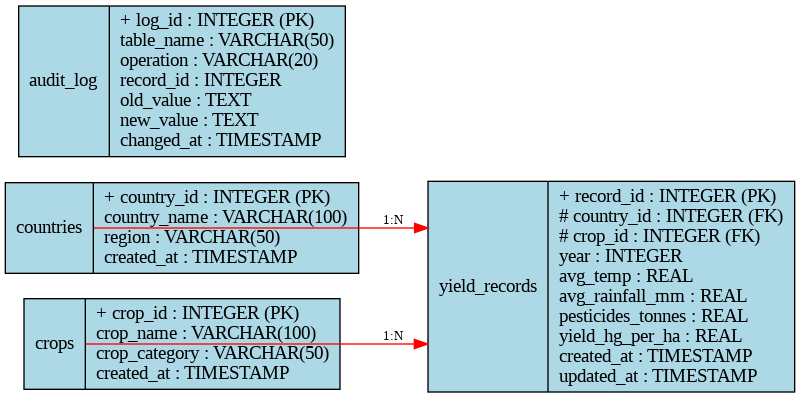

In [11]:
# ============================================================================
# PART 11: CREATE ERD DIAGRAM
# ============================================================================

print("\n" + "=" * 60)
print("STEP 11: Creating ERD Diagram")
print("=" * 60)

from graphviz import Digraph

# Create ERD
erd = Digraph('ERD', filename='crop_yield_erd', format='png')
erd.attr(rankdir='LR', splines='ortho')
erd.attr('node', shape='record', style='filled', fillcolor='lightblue')

# Define tables
erd.node('countries', '''{<pk> countries|
+ country_id : INTEGER (PK)\\l
country_name : VARCHAR(100)\\l
region : VARCHAR(50)\\l
created_at : TIMESTAMP\\l}''')

erd.node('crops', '''{<pk> crops|
+ crop_id : INTEGER (PK)\\l
crop_name : VARCHAR(100)\\l
crop_category : VARCHAR(50)\\l
created_at : TIMESTAMP\\l}''')

erd.node('yield_records', '''{<pk> yield_records|
+ record_id : INTEGER (PK)\\l
# country_id : INTEGER (FK)\\l
# crop_id : INTEGER (FK)\\l
year : INTEGER\\l
avg_temp : REAL\\l
avg_rainfall_mm : REAL\\l
pesticides_tonnes : REAL\\l
yield_hg_per_ha : REAL\\l
created_at : TIMESTAMP\\l
updated_at : TIMESTAMP\\l}''')

erd.node('audit_log', '''{<pk> audit_log|
+ log_id : INTEGER (PK)\\l
table_name : VARCHAR(50)\\l
operation : VARCHAR(20)\\l
record_id : INTEGER\\l
old_value : TEXT\\l
new_value : TEXT\\l
changed_at : TIMESTAMP\\l}''')

# Define relationships
erd.edge('countries:pk', 'yield_records:pk', label='1:N', color='red', fontsize='10')
erd.edge('crops:pk', 'yield_records:pk', label='1:N', color='red', fontsize='10')

# Render and save
erd.render()
print("✓ ERD Diagram created: crop_yield_erd.png")

# Display the ERD
from IPython.display import Image, display
display(Image('crop_yield_erd.png'))

In [12]:
# ============================================================================
# PART 12: EXPORT RESULTS
# ============================================================================

print("\n" + "=" * 60)
print("STEP 12: Exporting Results")
print("=" * 60)

# Export SQL schema
with open('schema.sql', 'w') as f:
    f.write("-- CROP YIELD DATABASE SCHEMA\n\n")
    f.write("-- Countries Table\n")
    f.write("""CREATE TABLE countries (
    country_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_name VARCHAR(100) UNIQUE NOT NULL,
    region VARCHAR(50),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);\n\n""")

    f.write("-- Crops Table\n")
    f.write("""CREATE TABLE crops (
    crop_id INTEGER PRIMARY KEY AUTOINCREMENT,
    crop_name VARCHAR(100) UNIQUE NOT NULL,
    crop_category VARCHAR(50),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);\n\n""")

    f.write("-- Yield Records Table\n")
    f.write("""CREATE TABLE yield_records (
    record_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER NOT NULL,
    crop_id INTEGER NOT NULL,
    year INTEGER NOT NULL,
    avg_temp REAL,
    avg_rainfall_mm REAL,
    pesticides_tonnes REAL,
    yield_hg_per_ha REAL,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY (country_id) REFERENCES countries(country_id),
    FOREIGN KEY (crop_id) REFERENCES crops(crop_id),
    CHECK (year >= 1900 AND year <= 2100),
    CHECK (yield_hg_per_ha >= 0)
);\n\n""")

    f.write("-- Audit Log Table\n")
    f.write("""CREATE TABLE audit_log (
    log_id INTEGER PRIMARY KEY AUTOINCREMENT,
    table_name VARCHAR(50),
    operation VARCHAR(20),
    record_id INTEGER,
    old_value TEXT,
    new_value TEXT,
    changed_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);\n""")

print("✓ SQL schema exported to: schema.sql")

# Export sample queries
with open('sample_queries.sql', 'w') as f:
    f.write("-- SAMPLE QUERIES FOR CROP YIELD DATABASE\n\n")
    f.write("-- 1. Top countries by average yield\n")
    f.write("""SELECT
    c.country_name,
    ROUND(AVG(yr.yield_hg_per_ha), 2) as avg_yield,
    COUNT(*) as num_records
FROM yield_records yr
JOIN countries c ON yr.country_id = c.country_id
GROUP BY c.country_name
ORDER BY avg_yield DESC
LIMIT 10;\n\n""")

    f.write("-- 2. Yield trends over time\n")
    f.write("""SELECT
    year,
    COUNT(*) as num_records,
    ROUND(AVG(yield_hg_per_ha), 2) as avg_yield,
    ROUND(AVG(avg_rainfall_mm), 2) as avg_rainfall
FROM yield_records
GROUP BY year
ORDER BY year DESC;\n\n""")

print("✓ Sample queries exported to: sample_queries.sql")

# Download files
print("\n" + "=" * 60)
print("STEP 13: Download Files")
print("=" * 60)

print("\nDownloading files...")
files.download('crop_yield.db')
files.download('schema.sql')
files.download('sample_queries.sql')
files.download('crop_yield_erd.png')

print("\n" + "=" * 60)
print("✓ ALL TASKS COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("\nSummary:")
print("✓ SQLite database created with 4 tables")
print("✓ MongoDB collections created and populated")
print("✓ 2 triggers implemented (audit logging & timestamp)")
print("✓ 2 stored procedures created")
print("✓ ERD diagram generated")
print("✓ All files exported and ready for download")
print("\nFiles created:")
print("  1. crop_yield.db - SQLite database")
print("  2. schema.sql - Database schema")
print("  3. sample_queries.sql - Example queries")
print("  4. crop_yield_erd.png - ERD diagram")

# Close connections
conn.close()
client.close()

print("\n✓ Database connections closed.")
print("\n" + "=" * 60)


STEP 12: Exporting Results
✓ SQL schema exported to: schema.sql
✓ Sample queries exported to: sample_queries.sql

STEP 13: Download Files



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ ALL TASKS COMPLETED SUCCESSFULLY!

Summary:
✓ SQLite database created with 4 tables
✓ MongoDB collections created and populated
✓ 2 triggers implemented (audit logging & timestamp)
✓ 2 stored procedures created
✓ ERD diagram generated
✓ All files exported and ready for download

Files created:
  1. crop_yield.db - SQLite database
  2. schema.sql - Database schema
  3. sample_queries.sql - Example queries
  4. crop_yield_erd.png - ERD diagram

✓ Database connections closed.



In [14]:
 # ============================================================================

# Task 2: Basic CRUD Operations (Create, Read, Update, Delete)
# ============================================================================

# STEP 1: Install required packages
print("=" * 60)
print("Installing Required Packages...")
print("=" * 60)
!pip install fastapi uvicorn pyngrok nest-asyncio -q

print("✓ Packages installed!")

# STEP 2: Import libraries
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from typing import Optional, List
import sqlite3
from contextlib import contextmanager
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import asyncio # Import asyncio
import json

nest_asyncio.apply()

# STEP 3: Database configuration
SQLITE_DB = "crop_yield.db"

@contextmanager
def get_db_connection():
    conn = sqlite3.connect(SQLITE_DB)
    conn.row_factory = sqlite3.Row
    try:
        yield conn
    finally:
        conn.close()

# STEP 4: Define data models
class YieldRecord(BaseModel):
    country_id: int
    crop_id: int
    year: int = Field(..., ge=1900, le=2100)
    avg_temp: Optional[float] = None
    avg_rainfall_mm: Optional[float] = None
    pesticides_tonnes: Optional[float] = None
    yield_hg_per_ha: float = Field(..., ge=0)

# STEP 5: Initialize FastAPI
app = FastAPI(
    title="Crop Yield Database API",
    description="Simple CRUD API for Crop Yield Records",
    version="1.0.0"
)

Installing Required Packages...
✓ Packages installed!


In [15]:
# ============================================================================
# CRUD ENDPOINTS -
# ============================================================================

@app.get("/")
async def root():
    """API information"""
    return {
        "message": "Crop Yield Database API",
        "version": "1.0.0",
        "endpoints": {
            "create": "POST /api/yield-records",
            "read": "GET /api/yield-records",
            "update": "PUT /api/yield-records/{id}",
            "delete": "DELETE /api/yield-records/{id}",
            "docs": "/docs"
        }
    }

# CREATE (POST)
@app.post("/api/yield-records", tags=["CRUD"])
async def create_record(record: YieldRecord):
    """CREATE - Add a new yield record"""
    with get_db_connection() as conn:
        cursor = conn.cursor()

        # Validate foreign keys
        cursor.execute("SELECT country_id FROM countries WHERE country_id = ?", (record.country_id,))
        if not cursor.fetchone():
            raise HTTPException(status_code=404, detail="Country not found")

        cursor.execute("SELECT crop_id FROM crops WHERE crop_id = ?", (record.crop_id,))
        if not cursor.fetchone():
            raise HTTPException(status_code=404, detail="Crop not found")

        # Insert record
        cursor.execute("""
            INSERT INTO yield_records
            (country_id, crop_id, year, avg_temp, avg_rainfall_mm, pesticides_tonnes, yield_hg_per_ha)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (
            record.country_id, record.crop_id, record.year,
            record.avg_temp, record.avg_rainfall_mm,
            record.pesticides_tonnes, record.yield_hg_per_ha
        ))
        conn.commit()

        return {
            "message": "Record created successfully",
            "record_id": cursor.lastrowid,
            "data": dict(record)
        }

# READ (GET)
@app.get("/api/yield-records", tags=["CRUD"])
async def read_records(
    record_id: Optional[int] = None,
    country_id: Optional[int] = None,
    crop_id: Optional[int] = None,
    limit: int = 100
):
    """READ - Get yield records (all or filtered)"""
    with get_db_connection() as conn:
        cursor = conn.cursor()

        # If specific record_id provided, return single record
        if record_id:
            cursor.execute("""
                SELECT
                    yr.record_id,
                    c.country_name,
                    cr.crop_name,
                    yr.year,
                    yr.avg_temp,
                    yr.avg_rainfall_mm,
                    yr.pesticides_tonnes,
                    yr.yield_hg_per_ha
                FROM yield_records yr
                JOIN countries c ON yr.country_id = c.country_id
                JOIN crops cr ON yr.crop_id = cr.crop_id
                WHERE yr.record_id = ?
            """, (record_id,))
            row = cursor.fetchone()
            if not row:
                raise HTTPException(status_code=404, detail="Record not found")
            return dict(row)

        # Otherwise return list with optional filters
        query = """
            SELECT
                yr.record_id,
                c.country_name,
                cr.crop_name,
                yr.year,
                yr.avg_temp,
                yr.avg_rainfall_mm,
                yr.pesticides_tonnes,
                yr.yield_hg_per_ha
            FROM yield_records yr
            JOIN countries c ON yr.country_id = c.country_id
            JOIN crops cr ON yr.crop_id = cr.crop_id
            WHERE 1=1
        """
        params = []

        if country_id:
            query += " AND yr.country_id = ?"
            params.append(country_id)
        if crop_id:
            query += " AND yr.crop_id = ?"
            params.append(crop_id)

        query += " ORDER BY yr.year DESC LIMIT ?"
        params.append(limit)

        cursor.execute(query, params)
        return [dict(row) for row in cursor.fetchall()]

# UPDATE (PUT)
@app.put("/api/yield-records/{record_id}", tags=["CRUD"])
async def update_record(record_id: int, record: YieldRecord):
    """UPDATE - Modify an existing yield record"""
    with get_db_connection() as conn:
        cursor = conn.cursor()

        # Check if record exists
        cursor.execute("SELECT record_id FROM yield_records WHERE record_id = ?", (record_id,))
        if not cursor.fetchone():
            raise HTTPException(status_code=404, detail="Record not found")

        # Update record
        cursor.execute("""
            UPDATE yield_records
            SET country_id = ?, crop_id = ?, year = ?,
                avg_temp = ?, avg_rainfall_mm = ?,
                pesticides_tonnes = ?, yield_hg_per_ha = ?
            WHERE record_id = ?
        """, (
            record.country_id, record.crop_id, record.year,
            record.avg_temp, record.avg_rainfall_mm,
            record.pesticides_tonnes, record.yield_hg_per_ha,
            record_id
        ))
        conn.commit()

        return {
            "message": "Record updated successfully",
            "record_id": record_id,
            "data": dict(record)
        }

# DELETE (DELETE)
@app.delete("/api/yield-records/{record_id}", tags=["CRUD"])
async def delete_record(record_id: int):
    """DELETE - Remove a yield record"""
    with get_db_connection() as conn:
        cursor = conn.cursor()

        cursor.execute("DELETE FROM yield_records WHERE record_id = ?", (record_id,))

        if cursor.rowcount == 0:
            raise HTTPException(status_code=404, detail="Record not found")

        conn.commit()

        return {
            "message": "Record deleted successfully",
            "record_id": record_id
        }

In [16]:
# ============================================================================
# HELPER ENDPOINTS
# ============================================================================

@app.get("/api/countries", tags=["Helpers"])
async def get_countries():
    """Get all countries (helper for testing)"""
    with get_db_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT * FROM countries ORDER BY country_name")
        return [dict(row) for row in cursor.fetchall()]

@app.get("/api/crops", tags=["Helpers"])
async def get_crops():
    """Get all crops (helper for testing)"""
    with get_db_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT * FROM crops ORDER BY crop_name")
        return [dict(row) for row in cursor.fetchall()]